# Clone repository and install requirements

In [1]:
import sys
sys.path.append('C:/Users/asus/text2face/FGTD/scripts')

# Import dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.optimizer import Optimizer, required

from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

In [3]:
from pytorch_fid.inception import InceptionV3
from ignite.metrics import FID

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# wrapper class as feature_extractor
class WrapperInceptionV3(nn.Module):

    def __init__(self, fid_incv3):
        super().__init__()
        self.fid_incv3 = fid_incv3

    @torch.no_grad()
    def forward(self, x):
        y = self.fid_incv3(x)
        y = y[0]
        y = y[:, :, 0, 0]
        return y

# pytorch_fid model
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to('cpu')

# wrapper model to pytorch_fid model
wrapper_model = WrapperInceptionV3(model)
wrapper_model.eval();

# comparable metric
pytorch_fid_metric = FID(num_features=dims, feature_extractor=wrapper_model)
def eval_step(engine, batch):
    return batch
default_evaluator = Engine(eval_step)
pytorch_fid_metric.attach(default_evaluator, "fid")

In [4]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

## Initializing helper functions

In [5]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Initializing constants

In [6]:
@dataclass
class Config:
    epochs: int = 101
    batch_size: int = 16
    subset_size: int = 30_000

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    num_channels: int = 3
    attention: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 768

    g_lr: float = 0.0001
    d_lr: float = 0.0004

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
cfg = Config()
cfg_dict = asdict(cfg)

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [8]:
# File Constants
ZIP_PATH = "."
OUTPUT_DIR = "C:/Users/asus/text2face/FGTD/dataset/img_align_celeba/"

# Create Sentence Encoder

In [10]:
sentence_encoder = SentenceEncoder(cfg.device)

# Create DataLoader

In [11]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/asus/text2face/FGTD/dataset/celebA_bangla.csv',  
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/asus/text2face/FGTD/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 30000
Classes present:  {'টুপি_পরা', 'দাড়ি_নেই', 'Unnamed: 0', 'চশমা', 'সামনের চুল কম', 'লিপস্টিক_পরা', 'পুরুষ', 'ঢেউ_খেলানো_চুল', 'ডিম্বাকৃতির_চেহারা', 'টাক', 'সরু_চোখ', 'উঁচু_গালের_হাড়', 'আকর্ষণীয়', 'কালো_চুল', 'মোছ', 'ভারী_মেকাপ', 'সোজা_চুল', 'হালকা_দাড়ি', 'বড়_নাক', 'বাদামী_চুল', 'গোটি', 'টাই_পরা', 'মোটা', 'অল্পবয়স্ক', 'নেকলেস_পরা', 'হাসি', 'ফ্যাকাশে', 'কানের_দুল_পরা', 'চোখা_নাক', 'মুখ_কিছুটা_খোলা', 'কপালে_ছড়ানো_চুল', 'সোনালী_চুল', 'ঘন_ভ্রু', 'দ্বীত্ব_থুতনি', 'চোখের_নিচে_কালি', 'বড়_ঠোঁট', 'গোলাপী_গাল', 'কুচকানো_ভুরু', 'জুলফি', 'ধূসর_চুল'}
Number of classes:  40
Length of subset dataset: 30000


  0%|          | 0/30000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing DataLoader output

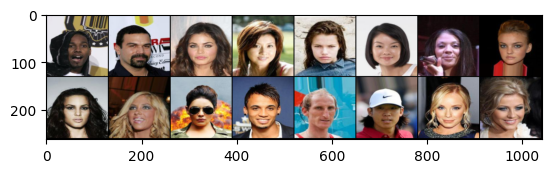

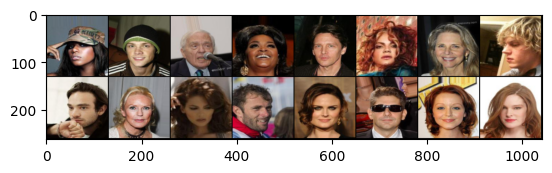

['ছেলেটির ভ্রু কুচকানো ছিল। ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় ঠোঁট ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির কালো চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির সামনের চুল কম ছিল। ছেলেটির মুখে ছিল হাসি। ', 'ভদ্রলোকটির চোখের নিচে কালি ছিল। ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের কালো চুল ছিল। ভদ্রলোকের সোনালী চুল ছিল। ভদ্রলোকেটি দেখতে মোটা ছিল। ভদ্রলোকের মুখে গোটি দাঁড়ি ছিল। ভদ্রলোকের মুখে মোছ ছিল। ভদ্রলোকটির জুলফি ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির বড় ঠোঁট ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির চোখা নাক ছিল। মেয়েটির গোলাপী গাল ছিল। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। মেয়েটির নেকলেস পরা ছিল। ', 'ছেলেটির মুখে ছিল হালকা দাড়ি। ছেলেটির দাড়ি নেই। ছেলেটির চেহারা ফ্যাকাশে। ', 'মেয়েটির কাল

In [12]:
images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Creating BERT sent embeddings

In [13]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[-0.2019,  0.1571, -0.3661,  ...,  0.6953,  0.4615,  0.1337],
        [ 0.0205,  0.3387, -0.6440,  ...,  0.3682,  0.1606,  0.0026],
        [-0.1701, -0.0042, -0.7202,  ...,  0.0463, -0.1025,  0.1888],
        ...,
        [-0.1278,  0.1354, -0.3129,  ...,  0.8942,  0.4419,  0.2952],
        [-0.1498, -0.0259, -0.6854,  ...,  0.0997, -0.0505,  0.1742],
        [-0.0932, -0.1044, -0.4281,  ...,  0.1380, -0.0372,  0.0932]],
       device='cuda:0')
torch.Size([16, 768])


## Initialize weights

In [14]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Defining Attention Module

In [15]:
class Self_Attn(nn.Module):
  '''
  Self attention layer
  '''
  def __init__(self, in_dim):
    super().__init__()

    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim = -1)


  def forward(self, x):
    batch_size, C, width, height = x.size()
    query = self.query_conv(x).view(batch_size, -1, width * height).permute(0,2, 1)
    key = self.key_conv(x).view(batch_size, -1, width * height)
    energy = torch.bmm(query, key)

    attn = self.softmax(energy)
    value = self.value_conv(x).view(batch_size, -1, width * height)
    out = torch.bmm(value, attn.permute(0, 2, 1))
    out = out.view(batch_size, C, width, height)

    out = self.gamma * out + x
    return out, attn

In [16]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [17]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [18]:
class Generator(nn.Module):
  '''
  Generator architecture
  '''
  def __init__(self, noise_size, embedding_size, reduced_dim_size, num_channels, image_size, attn = True, feature_size = 64):
    super(Generator, self).__init__()
    self.attn = attn
    self.noise_dim = noise_size
    
    assert image_size in [64, 128, 256], "Can only generate images for 64, 128 and 256 dimensions."
    self.image_size = image_size

    ########## Embedding Layer ##########
    self.encode_layer = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.BatchNorm1d(reduced_dim_size),
        nn.ReLU(),
        nn.Linear(reduced_dim_size, noise_size),
        nn.BatchNorm1d(noise_size),
        nn.ReLU(),
    )

    # Size 1 -> 4
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = noise_size, out_channels = feature_size*8, kernel_size = 4)),
        nn.BatchNorm2d(feature_size*8),
        nn.ReLU()
    )
    
    # Size 4 -> 8
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*8, out_channels = feature_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*4),
        nn.ReLU()
    )
    
    # Size 8 -> 16
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*4, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )

    # Attn1 layer turn 16 dims -> 16 dims
    self.attn1 = Self_Attn(feature_size*2)
    
    # Size 16 -> 32
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )
    
    # Attn2 layer turn 32 dims -> 32 dims
    self.attn2 = Self_Attn(feature_size*2)

    final_size = feature_size * 2
    
    if image_size >= 128:
        # Size 32 -> 64
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU()
        )

        final_size = feature_size * 2

        # Attn3 layer turn 64 dims -> 64 dims
        self.attn3 = Self_Attn(feature_size*2)

        if image_size == 256:
            # Size 64 -> 128
            self.layer6 = nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size, kernel_size = 4, stride = 2, padding = 1)),
                nn.BatchNorm2d(feature_size),
                nn.ReLU()
            )

            final_size = feature_size

        

    # Output last_dim -> last_dim * 2
    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(final_size, 3, 4, 2, 1),
        nn.Tanh()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.0, 0.9))

  def forward(self, noise, text_embeddings):
    encoded_text = self.encode_layer(text_embeddings)
    # Concatenating the noise and encoded text
    concat_input = torch.mul(noise, encoded_text).view(-1, self.noise_dim, 1, 1)
    
    x = self.layer1(concat_input)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)
        

    x = self.output_layer(x)
    return x


In [19]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.cuda()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=768, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

torch.Size([16, 3, 128, 128])


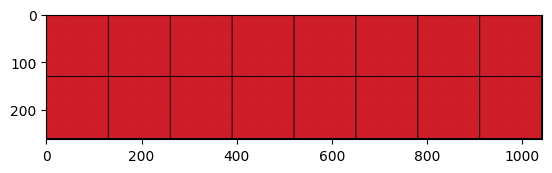

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=768, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [20]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [21]:
class Discriminator(nn.Module):
  '''
  Discriminator architecture
  '''
  def __init__(self, num_channels, feature_size, attn, image_size, embedding_size, reduced_dim_size):
    super(Discriminator, self).__init__()
    self.reduced_dim_size = reduced_dim_size
    self.attn = attn
    self.image_size = image_size

    # Size 256/128/64 -> 128/64/32
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.Conv2d(num_channels, feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Size 128/64/32 -> 64/32/16
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Size 64/32/16 -> 32/16/8
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size , feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Attn1 layer remains the same dim and size
    self.attn1 = Self_Attn(feature_size)
    
    # Size 32/16/8 -> 16/8/4
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Attn2 layer remains the same dim and size
    self.attn2 = Self_Attn(feature_size)

    if image_size >= 128:
        # Size 16/8 -> 8/4
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.Conv2d(feature_size, feature_size, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )

        self.attn3 = Self_Attn(feature_size)

        if image_size == 256:
            # Size 8 -> 4

            self.layer6 = nn.Sequential(
                SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
                nn.LeakyReLU(0.1)
            )
            
            feature_size = feature_size * 2

    ########## Text Encode ##########
    self.encode_text = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.LeakyReLU(0.2, inplace=True)
    )

    ########## Text + Image Concate Layer ##########
    self.image_text_layer = nn.Sequential(
        nn.Conv2d(feature_size + reduced_dim_size, feature_size * 8, 1, 1, 0, bias=False),
        nn.BatchNorm2d(feature_size * 8),
        nn.LeakyReLU(0.2,inplace=True),
    )

    ########## Output Layer ##########
    self.output_layer = nn.Sequential(
        nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0004, betas=(0.0, 0.9))

  def forward(self, input_images, text_embeddings):
    x = self.layer1(input_images)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)

    ## Text ##
    encoded_text = self.encode_text(text_embeddings)
    encoded_text = encoded_text.unsqueeze(2).unsqueeze(2).repeat(1, 1, 4, 4)

    ## Text + Image ##
    concat_output = self.image_text_layer(torch.cat([x, encoded_text], dim=1))
    output = self.output_layer(concat_output)

    return output.view(-1, 1)


In [22]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.cuda()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [23]:
with torch.no_grad():
  discriminator.eval()
  validity = discriminator(output, text_embeddings)
  print('output shape: ',output.shape)
  print('text_embeddings shape: ', text_embeddings.shape)
  print(validity.shape)
discriminator.train()

output shape:  torch.Size([16, 3, 128, 128])
text_embeddings shape:  torch.Size([16, 768])
torch.Size([16, 1])


Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

## Plotting output after each epoch

In [24]:
plt_images, plt_labels, plt_wrong = weighted_dataiter._next_data()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([16, 768])

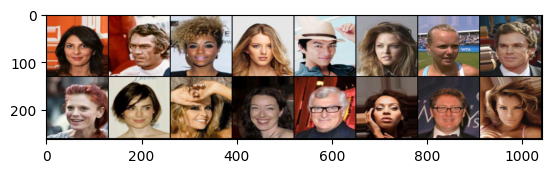

['মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির কপালে ছড়ানো চুল ছিল। মেয়েটির কালো চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির মুখে ছিল হাসি। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের সরু চোখ ছিল। ভদ্রলোকের দাড়ি নেই। ভদ্রলোকের সোজা চুল ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির কপালে ছড়ানো চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির মুখে ছিল হাসি। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'ছেলেটির বড় নাক ছিল। ছেলেটির দাড়ি নেই। ছেলেটির মুখে ছিল হাসি। ছেলেটির টুপি পরা ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির ঢেউ খেলানো চুল ছিল। ', 'মেয়েটির চোখের নিচে কালি ছিল। মেয়েটির বড় নাক ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খো

In [25]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [26]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [27]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

## Training

In [28]:
epoch = 0 # don't run when resuming. otherwise all training progress will be lost

In [29]:
checkpoint_path = "C:/Users/asus/text2face/FGTD/Face-GANs/SAGAN/cp.pt"

In [30]:
generator_path = 'C:/Users/asus/text2face/FGTD/Face-GANs/SAGAN/SAGAN_gd_generators/'

In [31]:
adversarial_loss = nn.BCELoss().cuda()

In [32]:
g_Losses = []
d_Losses = []

0it [00:00, ?it/s]

Epoch: 1 / 101
Discriminator Loss: 2.922, Generator Loss: 1.993
FID =  372.3753838030787


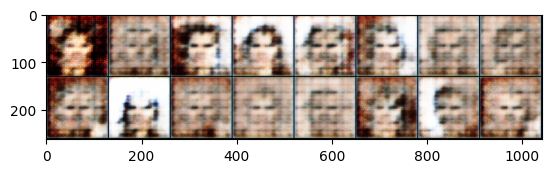

Epoch: 2 / 101
Discriminator Loss: 1.793, Generator Loss: 1.521
FID =  410.0484909145058


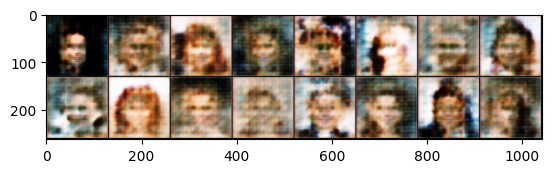

Epoch: 3 / 101
Discriminator Loss: 1.653, Generator Loss: 1.536
FID =  406.5519162759034


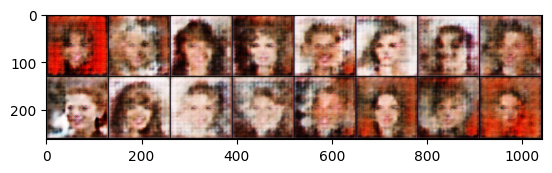

Epoch: 4 / 101
Discriminator Loss: 1.518, Generator Loss: 1.494
FID =  431.53021459567265


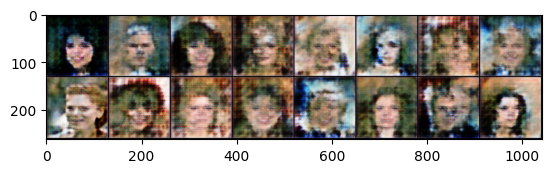

Epoch: 5 / 101
Discriminator Loss: 1.311, Generator Loss: 1.746
FID =  392.78716399326737


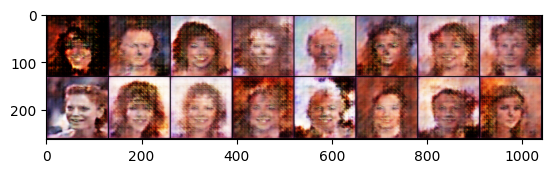

Epoch: 6 / 101
Discriminator Loss: 1.123, Generator Loss: 2.120
FID =  317.4511299955923


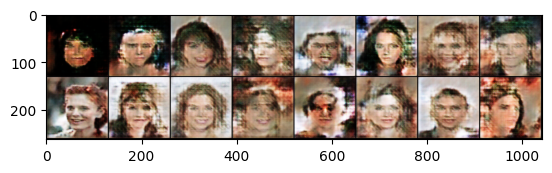

Epoch: 7 / 101
Discriminator Loss: 0.934, Generator Loss: 2.630
FID =  333.70708964218267


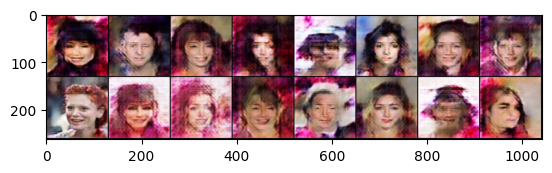

Epoch: 8 / 101
Discriminator Loss: 0.834, Generator Loss: 2.996
FID =  260.85060019354944


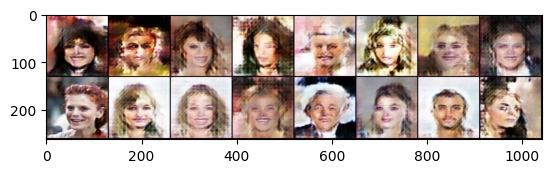

Epoch: 9 / 101
Discriminator Loss: 0.761, Generator Loss: 3.216
FID =  293.02202152118355


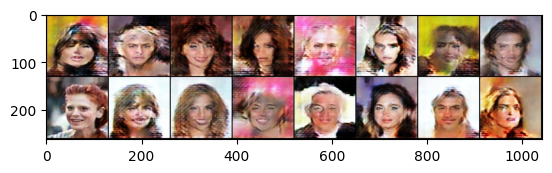

Epoch: 10 / 101
Discriminator Loss: 0.713, Generator Loss: 3.398
FID =  254.49105505896398


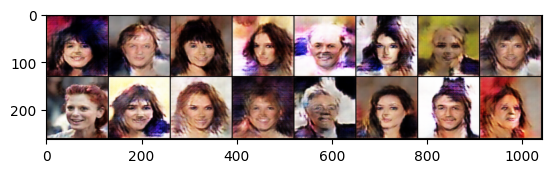

Epoch: 11 / 101
Discriminator Loss: 0.664, Generator Loss: 3.618
FID =  260.11605772572756


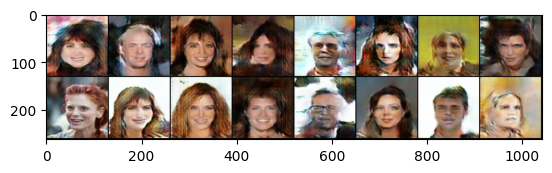

Epoch: 12 / 101
Discriminator Loss: 0.608, Generator Loss: 3.905
FID =  250.14024536294144


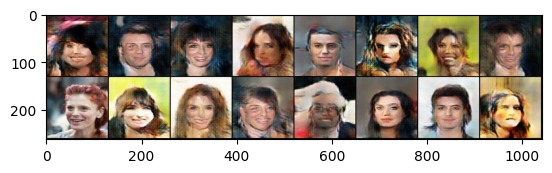

Epoch: 13 / 101
Discriminator Loss: 0.554, Generator Loss: 4.177
FID =  261.20946768631734


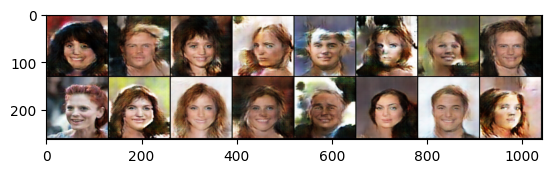

Epoch: 14 / 101
Discriminator Loss: 0.542, Generator Loss: 4.361
FID =  404.4282854495156


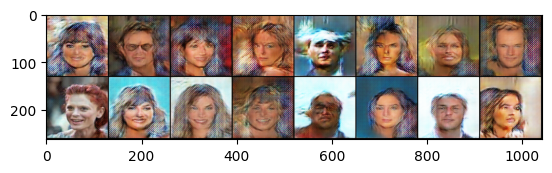

Epoch: 15 / 101
Discriminator Loss: 0.488, Generator Loss: 4.655
FID =  217.8519012264311


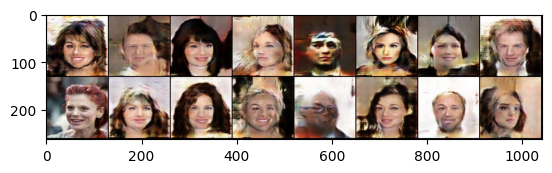

Epoch: 16 / 101
Discriminator Loss: 0.460, Generator Loss: 4.899
FID =  254.90954892669367


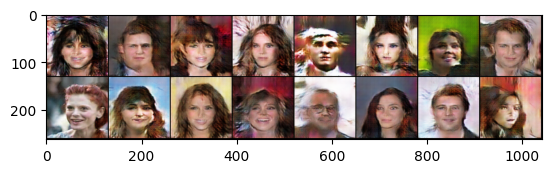

Epoch: 17 / 101
Discriminator Loss: 0.416, Generator Loss: 5.192
FID =  238.8580026368329


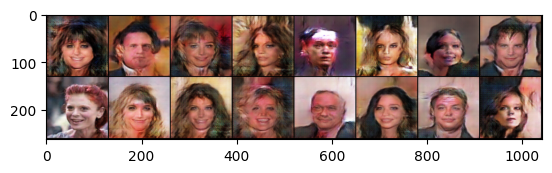

Epoch: 18 / 101
Discriminator Loss: 0.399, Generator Loss: 5.314
FID =  282.6260054971385


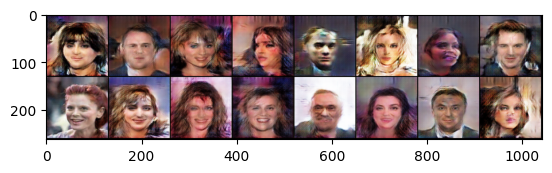

Epoch: 19 / 101
Discriminator Loss: 0.385, Generator Loss: 5.408
FID =  246.55554918078923


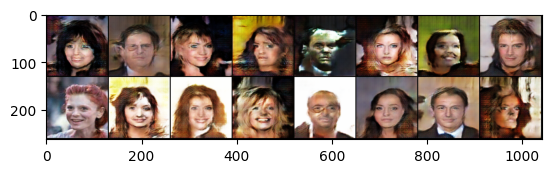

Epoch: 20 / 101
Discriminator Loss: 0.376, Generator Loss: 5.647
FID =  250.8657779060378


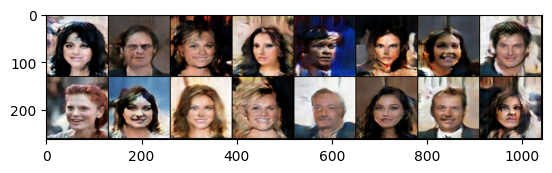

Epoch: 21 / 101
Discriminator Loss: 0.349, Generator Loss: 5.868
FID =  242.38349232970546


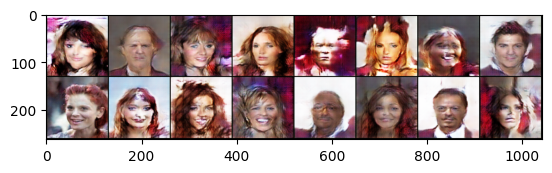

Epoch: 22 / 101
Discriminator Loss: 0.328, Generator Loss: 6.154
FID =  260.08156924599456


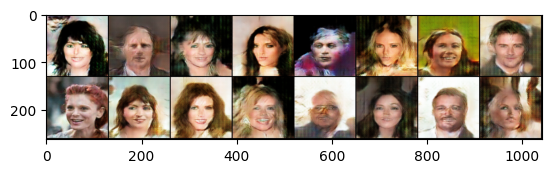

Epoch: 23 / 101
Discriminator Loss: 0.272, Generator Loss: 6.447
FID =  256.96537545568657


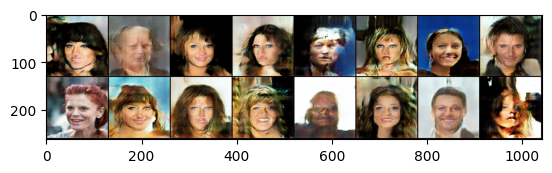

Epoch: 24 / 101
Discriminator Loss: 0.279, Generator Loss: 6.809
FID =  248.54936156940488


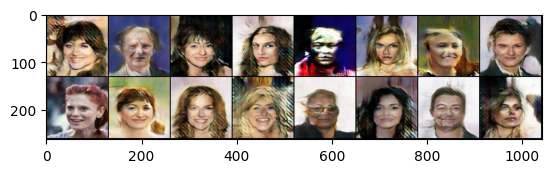

Epoch: 25 / 101
Discriminator Loss: 0.306, Generator Loss: 6.607
FID =  211.77985292394015


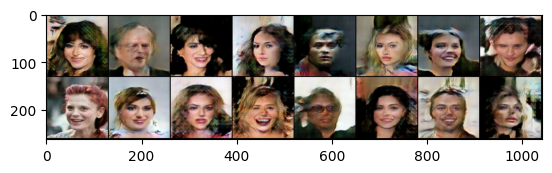

Epoch: 26 / 101
Discriminator Loss: 0.262, Generator Loss: 6.917
FID =  247.04368958403202


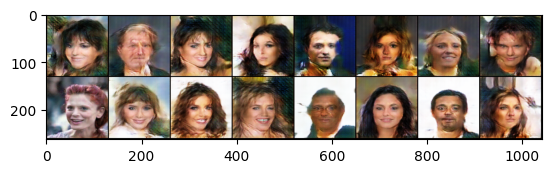

Epoch: 27 / 101
Discriminator Loss: 0.269, Generator Loss: 7.128
FID =  249.55907647699297


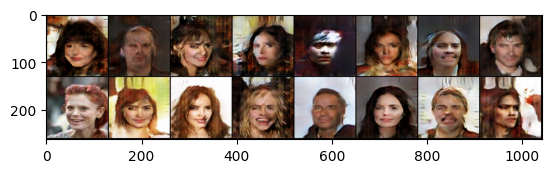

Epoch: 28 / 101
Discriminator Loss: 0.273, Generator Loss: 6.945
FID =  218.14711826002213


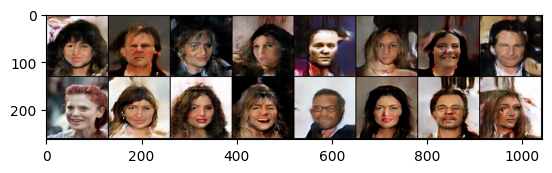

Epoch: 29 / 101
Discriminator Loss: 0.242, Generator Loss: 7.216
FID =  225.2868389778368


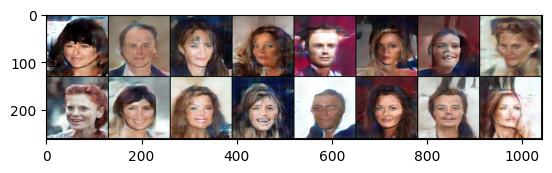

Epoch: 30 / 101
Discriminator Loss: 0.240, Generator Loss: 7.511
FID =  218.29790881967102


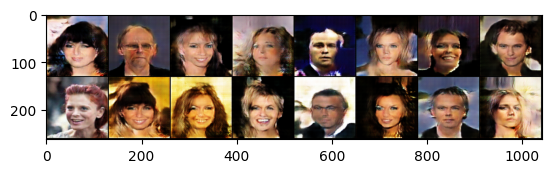

Epoch: 31 / 101
Discriminator Loss: 0.224, Generator Loss: 7.635
FID =  248.9281565999915


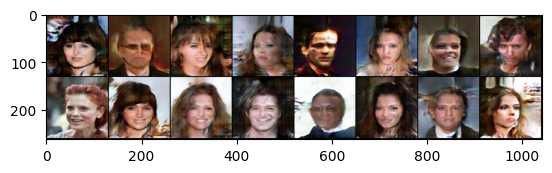

Epoch: 32 / 101
Discriminator Loss: 0.216, Generator Loss: 8.073
FID =  238.05947624587873


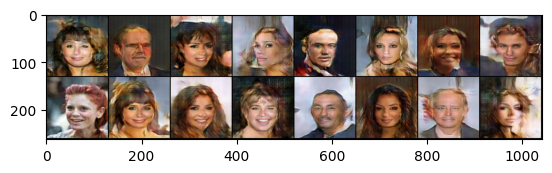

Epoch: 33 / 101
Discriminator Loss: 0.211, Generator Loss: 8.056
FID =  240.2880867433235


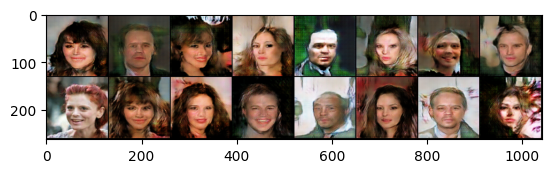

Epoch: 34 / 101
Discriminator Loss: 0.201, Generator Loss: 8.083
FID =  245.33155275531473


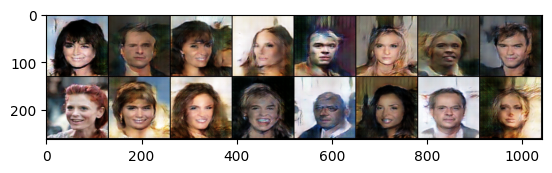

Epoch: 35 / 101
Discriminator Loss: 0.206, Generator Loss: 8.171
FID =  245.60749746377158


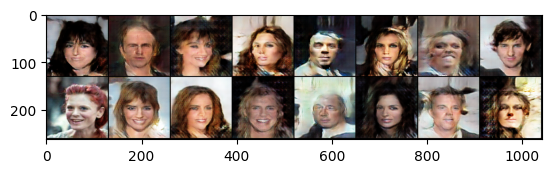

Epoch: 36 / 101
Discriminator Loss: 0.210, Generator Loss: 8.392
FID =  224.05656726574915


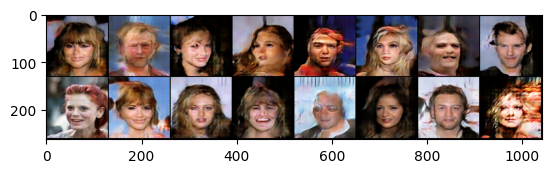

Epoch: 37 / 101
Discriminator Loss: 0.216, Generator Loss: 8.437
FID =  236.43685377958633


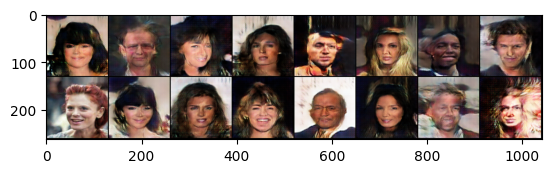

Epoch: 38 / 101


In [ ]:
pbar = tqdm()

# Converting dataset to cuda
# wandb.watch(generator)
# wandb.watch(discriminator)

while epoch<cfg.epochs:
    print(f'Epoch: {epoch + 1} / {cfg.epochs}')
    pbar.reset(total=len(weighted_dataloader))

    # Setting up losses
    discriminator_losses = []
    generator_losses = []
    
    x = None
    y = None
    
    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):

        # Current batch size
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda()
        wrong_images = wrong_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

        # For real vs fake
        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        # Train Generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        discriminator_fake_validity = discriminator(fake_images, text_embeddings)
        generator_loss = adversarial_loss(discriminator_fake_validity, real_validity)
        
        x = real_images.detach().clone()
        y = fake_images.detach().clone()
        
        generator_loss.backward()
        generator.optimizer.step()
        generator_losses.append(generator_loss)

        # Train Discriminator
        discriminator.zero_grad()

        ## To calculate real loss
        discriminator_real_validity = discriminator(real_images, text_embeddings)
        discriminator_real_loss = adversarial_loss(discriminator_real_validity, real_validity)

        ## To calculate wrong loss
        discriminator_wrong_validity = discriminator(wrong_images, text_embeddings)
        discriminator_wrong_loss = adversarial_loss(discriminator_wrong_validity, fake_validity)

        ## To calculate fake loss
        discriminator_fake_validity = discriminator(fake_images.detach(), text_embeddings)
        discriminator_fake_loss = adversarial_loss(discriminator_fake_validity, fake_validity)

        ## Calculating total loss
        discriminator_loss = discriminator_real_loss + discriminator_wrong_loss + discriminator_fake_loss
        discriminator_loss.backward()
        discriminator.optimizer.step()
        discriminator_losses.append(discriminator_loss)


        # Update tqdm
        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_losses)),
            torch.mean(torch.FloatTensor(generator_losses))
    ))
    
    
    state = default_evaluator.run([[x, y]])
    print('FID = ',state.metrics["fid"])
        
    with open('gd FID.txt', 'a') as f:
        f.write(str(state.metrics["fid"])+'\n')
    
    if (epoch + 1) % cfg.save_epoch == 0:
        plot_output(epoch + 1)

    g_Losses.append(torch.mean(torch.FloatTensor(generator_losses)))
    d_Losses.append(torch.mean(torch.mean(torch.FloatTensor(discriminator_losses))))

    checkpoint = {
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'generator_optimizer': generator.optimizer.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'discriminator_optimizer': discriminator.optimizer.state_dict(),
    'g_Losses' : g_Losses,
    'd_Losses' : d_Losses
    }

    torch.save(checkpoint,checkpoint_path)

    if epoch%5 == 0:
        gen_cp = {
        'epoch':epoch,
        'generator_sd':generator.state_dict()
        }
        torch.save(gen_cp,generator_path+str(epoch)+'.pt')


    epoch+=1


pbar.refresh()

# load checkpoint

In [33]:
checkpoint = torch.load(checkpoint_path)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.optimizer.load_state_dict(checkpoint['generator_optimizer'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
discriminator.optimizer.load_state_dict(checkpoint['discriminator_optimizer'])
g_Losses = checkpoint['g_Losses']
d_Losses = checkpoint['d_Losses']
epoch = checkpoint['epoch']
generator.train()
discriminator.train()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

# Plotting losses of D and G

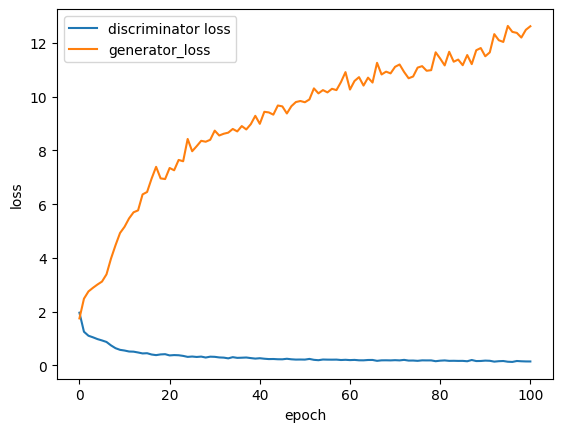

In [34]:
plt.plot(checkpoint['d_Losses'],label='discriminator loss')
plt.plot(checkpoint['g_Losses'],label='generator_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper left")
plt.show()

## Testing

In [35]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['মেয়েটির কপালে ছড়ানো চুল ছিল। মেয়েটির বড় ঠোঁট ছিল। মেয়েটির কালো চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির চোখা নাক ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির ঢেউ খেলানো চুল ছিল। মেয়েটির লিপস্টিক পরা ছিল। '])

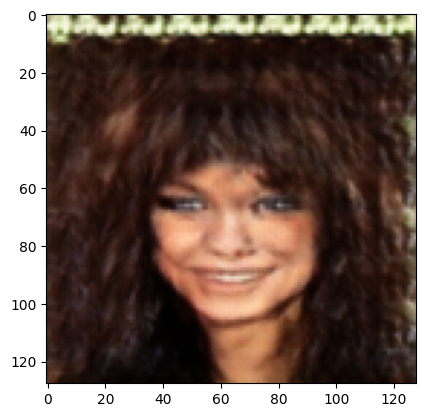

In [36]:
generator.eval()
discriminator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [37]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['ভদ্রলোকটির চোখের নিচে কালি ছিল। ভদ্রলোকের চোখে চশমা ছিল। ভদ্রলোকের ধূসর চুল ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের দাড়ি নেই। ভদ্রলোকটির মুখে ছিল হাসি। '])

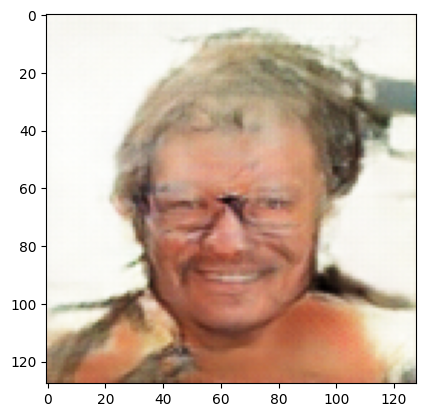

In [38]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

load model from checkpoint

In [48]:
PATH = "C:/Users/asus/text2face/FGTD/Face-GANs/SAGAN/checkpoint.pt"

In [50]:
model = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
model.load_state_dict(torch.load(PATH)['generator_state_dict'])
model.cuda()
model.eval()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

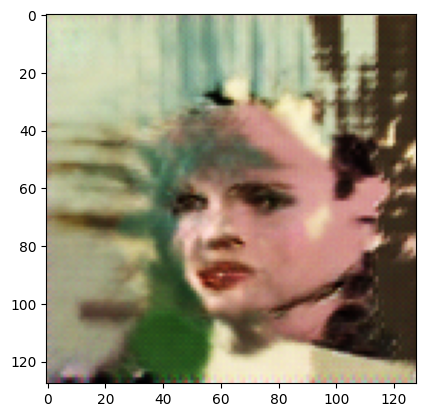

In [51]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['তার আছে কুচকানো ভুরু, বড় ঠোঁট, সরু চোখ এবং একটি চোখা নাক। ভদ্রলোকটি দেখায় আকর্ষণীয়, অল্পবয়স্ক এবং আছে ভারী মেকাপ। সে পরেছে লিপস্টিক।'])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))